<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Natural Language Processing
## Chatbot with deep leargning - Default query and answers 

Based on:
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Dependencies installation

In [2]:
# Install libraries
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [3]:
# Import libraries
import json
import string
import random
import numpy as np
import spacy
import stanza
import spacy_stanza
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

/home/benja/anaconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-03 17:32:26.227673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Download the dictionary in spanish
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2023-09-03 17:32:33 INFO: Downloading default packages for language: es (Spanish) ...
2023-09-03 17:32:36 INFO: File exists: /home/benja/stanza_resources/es/default.zip
2023-09-03 17:32:43 INFO: Finished downloading models and saved to /home/benja/stanza_resources.
2023-09-03 17:32:43 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-09-03 17:32:44 INFO: Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

2023-09-03 17:32:44 WARNING: GPU requested, but is not available!
2023-09-03 17:32:44 INFO: Using device: cpu
2023-09-03 17:32:44 INFO: Loading: tokenize
2023-09-03

In [5]:
# Initializing Device Specification
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU")
 
# Printing the DeviceSpec
print('Device Spec: ', device_spec.to_string())

Device Spec:  /job:localhost/replica:0/device:GPU:*


### 2 - Data processing tools

In [6]:
import re
import unicodedata

def preprocess_clean_text(text):    
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Delete special characters
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : None of this letters and symbols 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # Delete numbers
    text = re.sub(pattern, '', text)

    # Delete puntuaction characters
    text = ''.join([c for c in text if c not in string.punctuation])
    
    return text

In [7]:
text = "Asia!! Africa! EUROPA?! LATIONAMERICA"

# Before preprocessing convert to lowercase
preprocess_clean_text(text.lower())

'asia africa europa lationamerica'

In [8]:
text = "Asia!! Africa! EUROPA?! LATIONAMERICA"

# Before of the preprocessing the data are convert to lower case
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lemmatizattion for every token:")
for token in tokens:
    print([token, token.lemma_])

tokens: asia africa europa lationamerica
Lemmatizattion for every token:
[asia, 'asia']
[africa, 'africo']
[europa, 'europo']
[lationamerica, 'lationamerica']


### 3 - Preprocessing and dataset construction

In [11]:

#pre_nlp = spacy.load("es_core_news_sm")
# Word o vocabulary that will be necessary
words = []
classes = []
doc_X = []
doc_y = []

data=open('./data/data.json').read()
dataset=json.loads(data)
#Create a set of stop words
stop_words = spacy.lang.es.stop_words.STOP_WORDS

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # Transform the pattern in token
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # Lemmatizate the patterns in tokens
        for token in tokens:            
            if not token.is_stop:
                words.append(token.lemma_)    
        
            doc_X.append(pattern)
            doc_y.append(intent["tag"])
    
    # Add the tag to the class
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Delete the duplicate values with set and sort the vocabulary and the classes 
#in alphabetical order
words = sorted(set(words))
classes = sorted(set(classes))

In [12]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['adio', 'ayudarmar', 'chau', 'contacto', 'correo', 'costo', 'credito', 'criptomoneda', 'cuota', 'direccion', 'electronico', 'email', 'empresa', 'gracias', 'hola', 'indicar', 'llama', 'medio', 'mobile', 'nombre', 'numero', 'ofrecer', 'pago', 'poder', 'precio', 'producto', 'ser', 'servicio', 'silotok', 'tarjeta', 'telefono', 'ubicacion', 'ubicado', 'whatsapp']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'contacto_email', 'despedida', 'nombre', 'pagos', 'precios_servicios', 'servicios', 'ubicación_empresa']
doc_X: ['Hola', '¿Cómo estás?', '¿Cómo estás?', 'Hola, podrías ayudarme', 'Hola, podrías ayudarme', 'Hola, podrías ayudarme', '¿Cúal es tu nombre?', '¿Cúal es tu nombre?', '¿Cúal es tu nombre?', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Quién sos?', '¿Me podrías decir tú nombre?', '¿Me podrías decir tú nombre?', '¿Me podrías decir tú nombre?', '¿Me podrías decir tú nombre?', '¿Me podrías decir tú nombre?', '¿Como te llamas?', '¿Como te llamas?', '¿Como te llamas?', 'co

In [13]:
# Vocabulary size
print("Vocabulario:", len(words))

Vocabulario: 34


In [15]:
# Tag numbers
print("Tags:", len(classes))

Tags: 10


In [16]:
# Transform  doc_X in bag of words by oneHotEncoding
# Transform  doc_Y in a vector of multicategorical multiclass  with oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transform the input in tokens and lemmatizate
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transform the tokens in "BoW"
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Create the output array
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mix the data
random.shuffle(training)
training = np.array(training, dtype=object)
# Split in input and output data
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0

### 4 - Training model

In [17]:
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (34,) output: 10


In [19]:
# Create the model : 3 layers Training the model DNN
# - Sequential model
# - Regularization
# - softmax and Adam optimizer 
model = Sequential()
model.add(Dense(256, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))


#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               8960      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 10)               

In [20]:
with tf.device(device_spec):
    hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
3/3 [==============================] - 1s 20ms/step - loss: 2.2968 - accuracy: 0.1395
Epoch 2/200
3/3 [==============================] - 0s 31ms/step - loss: 2.2948 - accuracy: 0.0930
Epoch 3/200
3/3 [==============================] - 0s 10ms/step - loss: 2.2617 - accuracy: 0.1279
Epoch 4/200
3/3 [==============================] - 0s 15ms/step - loss: 2.2440 - accuracy: 0.1744
Epoch 5/200
3/3 [==============================] - 0s 10ms/step - loss: 2.2150 - accuracy: 0.1744
Epoch 6/200
3/3 [==============================] - 0s 24ms/step - loss: 2.1666 - accuracy: 0.3372
Epoch 7/200
3/3 [==============================] - 0s 6ms/step - loss: 2.1132 - accuracy: 0.3256
Epoch 8/200
3/3 [==============================] - 0s 19ms/step - loss: 2.1517 - accuracy: 0.2674
Epoch 9/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0646 - accuracy: 0.3605
Epoch 10/200
3/3 [==============================] - 0s 8ms/step - loss: 2.0353 - accuracy: 0.3372
Epoch 11/200
3/3 [====

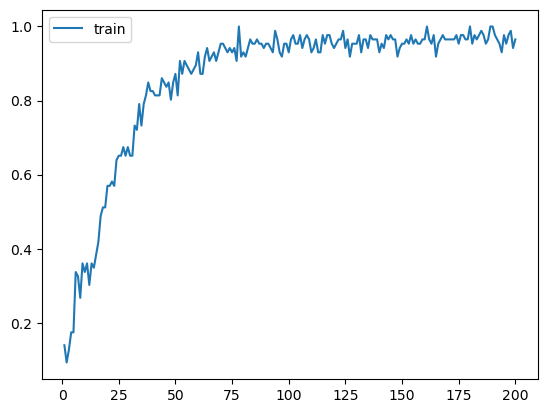

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Training
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [122]:
# Save the model for production
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 5 - Testing and validation

In [123]:
# Convert input text to tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)

    return lemma_tokens

# Transform the tokenized input text to OHE representation


def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1

    return np.array(bow)

# Using the model with the OHE input the labels


def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        # Filter inputs lower than the threshold
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # Sort keys according to the softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])

    return return_list

# Getting a default anwser


def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        if i["tag"] == tag:
            result = random.choice(i["responses"])
            break
    return result

In [124]:
while True:
    # Ask to the user for the input question
    message = input("")
    print("Question:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("SiloBOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("SiloBOT: Perdón, no entiendo tú pregunta.")
    

Question: Ubicación
1/1 [==============================] - 0s 49ms/step
SiloBOT: Hablamos luego!
Question: Hola
1/1 [==============================] - 0s 19ms/step
SiloBOT: Hola!
Question: Como te llamas? 
1/1 [==============================] - 0s 14ms/step
SiloBOT: Mi nombre es SiloBot, un bot asistido por AI
Question: Servicios
1/1 [==============================] - 0s 25ms/step
SiloBOT: La compañía ofrece los siguientes servicios: SiloView, SiloToken, SiloMetrix, información adicional la puedes encontrar en en el siguiente link
Question: Precios
SiloBOT: Perdón, no entiendo tú pregunta.
Question: Precios
SiloBOT: Perdón, no entiendo tú pregunta.
Question: 
SiloBOT: Perdón, no entiendo tú pregunta.
Question: 
SiloBOT: Perdón, no entiendo tú pregunta.


KeyboardInterrupt: Interrupted by user